### TELEMETRY TANQUES

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

In [2]:
# Cargamos el exel en un dataframe:

df=pd.read_excel(os.path.join('Telemetry.xlsx'))

In [3]:
# Obtenemos información de las etiquetas de las columnas:

info_column=df.columns.str.split('_')

# Obtenemos el nombre de la primera columna:

column1_name="".join(info_column[0])

# Obtenemos el tamaño del tanque, a partir de la etiqueta de la segunda columna:

tank_size=info_column[1][1]

#Obtenemos los digitos del tamaño:

tank_size=[tank_size[data] for data in range(len(tank_size)) if tank_size[data].isdigit()]
tank_size="".join(tank_size)

#Obtenemos el tipo de gas a partir de la etiqueta de la segunda columna:

gas_name=info_column[1][2]

In [4]:
print(column1_name,tank_size, gas_name,info_column)

Timestamp 19000 LN2 Index([                                                                                ['Timestamp'],
           ['[2574R', 'VRV19000E*', 'LN2', '2826] Tanque - Transmisor de Nivel - Nivel - Contenido'],
       ['[2574R', 'VRV19000E*', 'LN2', '2826] Tanque - Transmisor de presión - Presión - Contenido']],
      dtype='object')


In [5]:
# Cambiamos el nombre de las columnas:

df.columns=['Timestamp','Nivel (%)','Presion (bar)']

In [6]:
# Separamos el timestamp en fecha y hora:

df['Date'] = [d.date() for d in df['Timestamp']]
df['Time'] = [d.time() for d in df['Timestamp']]

In [7]:
# Reordeamos columnas:
df = df.reindex(columns=['Timestamp','Date','Time','Nivel (%)','Presion (bar)'])

# Ordenamos los datos de forma ascendente por fecha y hora:
df=df.sort_values(by=['Date','Time'])
df=df.reset_index(drop=True)

In [8]:
#Eliminamos valores NaN en la columna 'Presion':
df = df[df['Presion (bar)'].notna()]


In [9]:
# Cambiamos el formato de la fecha para extraer por año, mes, dia y dia de la semana:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.strftime('%Y')
df['Month'] = df['Date'].dt.strftime('%m')
df['Day'] = df['Date'].dt.strftime('%d')
df['Day_of_Week'] = df['Date'].dt.day_name()
df['Month_Name'] = df['Date'].dt.month_name()


In [10]:
df['Date'] =df['Date'].dt.strftime('%d-%m-%Y')

In [11]:
def season_selector(date):
    # Obtenemos la estación de año a partir de la fecha.
    season=['Winter','April','Summer','Autum']
    date=datetime.now()
    day=int(date.strftime("%d"))
    month=int(date.strftime("%m"))
    if (month >=1 and month <3) or (month ==12 and day >=21) or (month==3 and day < 21) :
        return season[0]
    if (month >3 and month < 6) or (month==6 and day<21) or (month==3 and day < 21):
        return season[1]
    if (month >6 and month < 9) or (month==6 and day>=21) or (month==9 and day<21):
        return season[2]
    if (month >9 and month < 12) or (month==9 and day >=21) or (month==12 and day<21):
        return season[3]

df['Season'] = df['Date'].apply(season_selector)

In [12]:
#Eliminamos valor 0 de la columna Nivel:
df=df.drop(df.loc[df['Nivel (%)']== 0].index)

In [13]:
# Creamos un columna en el Dataframe llamada Estado:
def inicio(nivel):
    
    num_valores=int(len(df['Nivel (%)']))
    
    if nivel == df['Nivel (%)'].iloc[0]:
        return "Inicio"
    if nivel == df['Nivel (%)'].iloc[(num_valores-1)]:
        return "Fin"
df['Estado']=df['Nivel (%)'].apply(inicio)

In [14]:
#Creamos lista con todos los niveles:
niveles=[nivel for nivel in df['Nivel (%)']]

In [15]:
def descarga_consumo():
    #Creamos una función que nos indica si el valor de nivel corresponde a un estado 
    #de consumo o llenado de la cisterna:

    operacion=['inicio']
    n=1
    while n <(len(niveles)-1):
        if niveles[n] > niveles[n+1] and niveles[n]< niveles[n-1]:
            operacion.append("Consumo")
            #print(f"{niveles[n]} > {niveles[n+1]} y {niveles[n]} < {niveles[n-1]}")
    
        elif niveles[n] < niveles[n+1] and niveles[n]> niveles[n-1]:
            operacion.append("Descarga")
            #print(f"{niveles[n]} < {niveles[n+1]} y {niveles[n]} > {niveles[n-1]}")
        
        elif niveles[n] < niveles[n+1] and niveles[n]< niveles[n-1]:
            if (niveles[n+1]-niveles[n])>0.3 and (niveles[n-1]-niveles[n])>0.3:
                operacion.append("Empieza Descarga")
            else:
                operacion.append("Consumo")
                
            #print(f"{niveles[n]} < {niveles[n+1]} y {niveles[n]} < {niveles[n-1]}")
        
        elif niveles[n] > niveles[n+1] and niveles[n]> niveles[n-1]:
            if (niveles[n]-niveles[n+1])>0.3 and (niveles[n]-niveles[n-1])>0.3:
                operacion.append("Termina Descarga")
            else:
                operacion.append("Consumo")
                
            #print(f"{niveles[n]}> {niveles[n+1]} y {niveles[n]} > {niveles[n-1]}")
        
        elif niveles[n] == niveles[n+1]:
            #print(f"{niveles[n]} == {niveles[n+1]}")
            operacion.append("Sin Consumo")
        
        elif niveles[n] == niveles[n-1]:
            #print(f"{niveles[n]} == {niveles[n-1]}")
            operacion.append("Sin Consumo")
        n+=1
    return operacion

In [16]:
# Clasificamos estado:

estado= descarga_consumo()

In [17]:
# Hacemos una copia del Dataframe y llenamos el campo Estado con su valor:
dff=df.copy()
mask=dff['Estado']
for n in range(len(estado)):
    mask.iloc[n]=estado[n]

/Users/javiertamarit/.local/share/virtualenvs/Ejercicios_Prog_Avanzada-OvvKQvod/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [18]:
#Exportamos el dataframe a excel:
dff.to_excel(os.path.join('output.xlsx'))

In [19]:
#Filtra dataframe por descargas:
descargas_df = dff[dff['Estado'] == 'Empieza Descarga']
descargas_df =descargas_df.reset_index(drop=True)

In [20]:
#Obtenemos el número de descargas:
numero_descargas = len(descargas_df)

In [21]:
# Calculamos las deltas de tiempo entre descargas y lo pasamos a una lista:

timestamps=[value for value in descargas_df['Timestamp']]

def delta_time_descargas(timestamps):
    
    delta_time=[0]
    
    for v in range(len(timestamps)-1):
        
        delta= timestamps[v+1]- timestamps[v]
        delta_time.append(delta)
        
    return delta_time

d=delta_time_descargas(timestamps)

In [22]:
#Creamos la columna Delta Time en el Dataframe:

def delta(timestamp):
    if timestamp == descargas_df['Timestamp'].iloc[0]:
        return 0
descargas_df['Delta Time']=descargas_df['Timestamp'].apply(delta)

In [23]:
# Pasamos la lista de Delta Time al Dataframe:

n=1
mask=descargas_df['Delta Time']
while n < numero_descargas:
    mask.iloc[n]=d[n]
    n += 1   

/Users/javiertamarit/.local/share/virtualenvs/Ejercicios_Prog_Avanzada-OvvKQvod/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [24]:
# Registo incidencia:

def incident(volumen):
    if volumen < 20.0:
        return "Run Out"
descargas_df['Incidencia']=descargas_df['Nivel (%)'].apply(incident)

In [26]:
# Definimos RunOuts:

runouts=descargas_df[descargas_df['Incidencia']=="Run Out"]
num_runouts=len(runouts)
print(f'Run Outs:',num_runouts)

Run Outs: 1


In [31]:
# Descargas Nominal:

def descargas_nominal():
    counter=0
    for element in descargas_df['Nivel (%)']:
        if element < 40 and element >20:
            counter += 1
    return counter

In [35]:
print(f'Descargas Nominal:',descargas_nominal())

Descargas Nominal: 3


In [33]:
# Descargas mayores del 40%:

def descargas_plus40():
    counter=0
    for element in descargas_df['Nivel (%)']:
        if element > 40:
            counter += 1
    return counter
    

In [36]:
print(f'Descargas > 40% :',descargas_plus40())

Descargas > 40% : 7


In [27]:
#Ordenamos por nivel del tanque a la descarga de mayor a menor:
descargas_df=descargas_df.sort_values(by=['Nivel (%)'], ascending=False)

In [28]:
#Customizamos la paleta de colores:
sns.set(style="whitegrid", color_codes=True)
pal=sns.color_palette("rainbow", len(descargas_df))

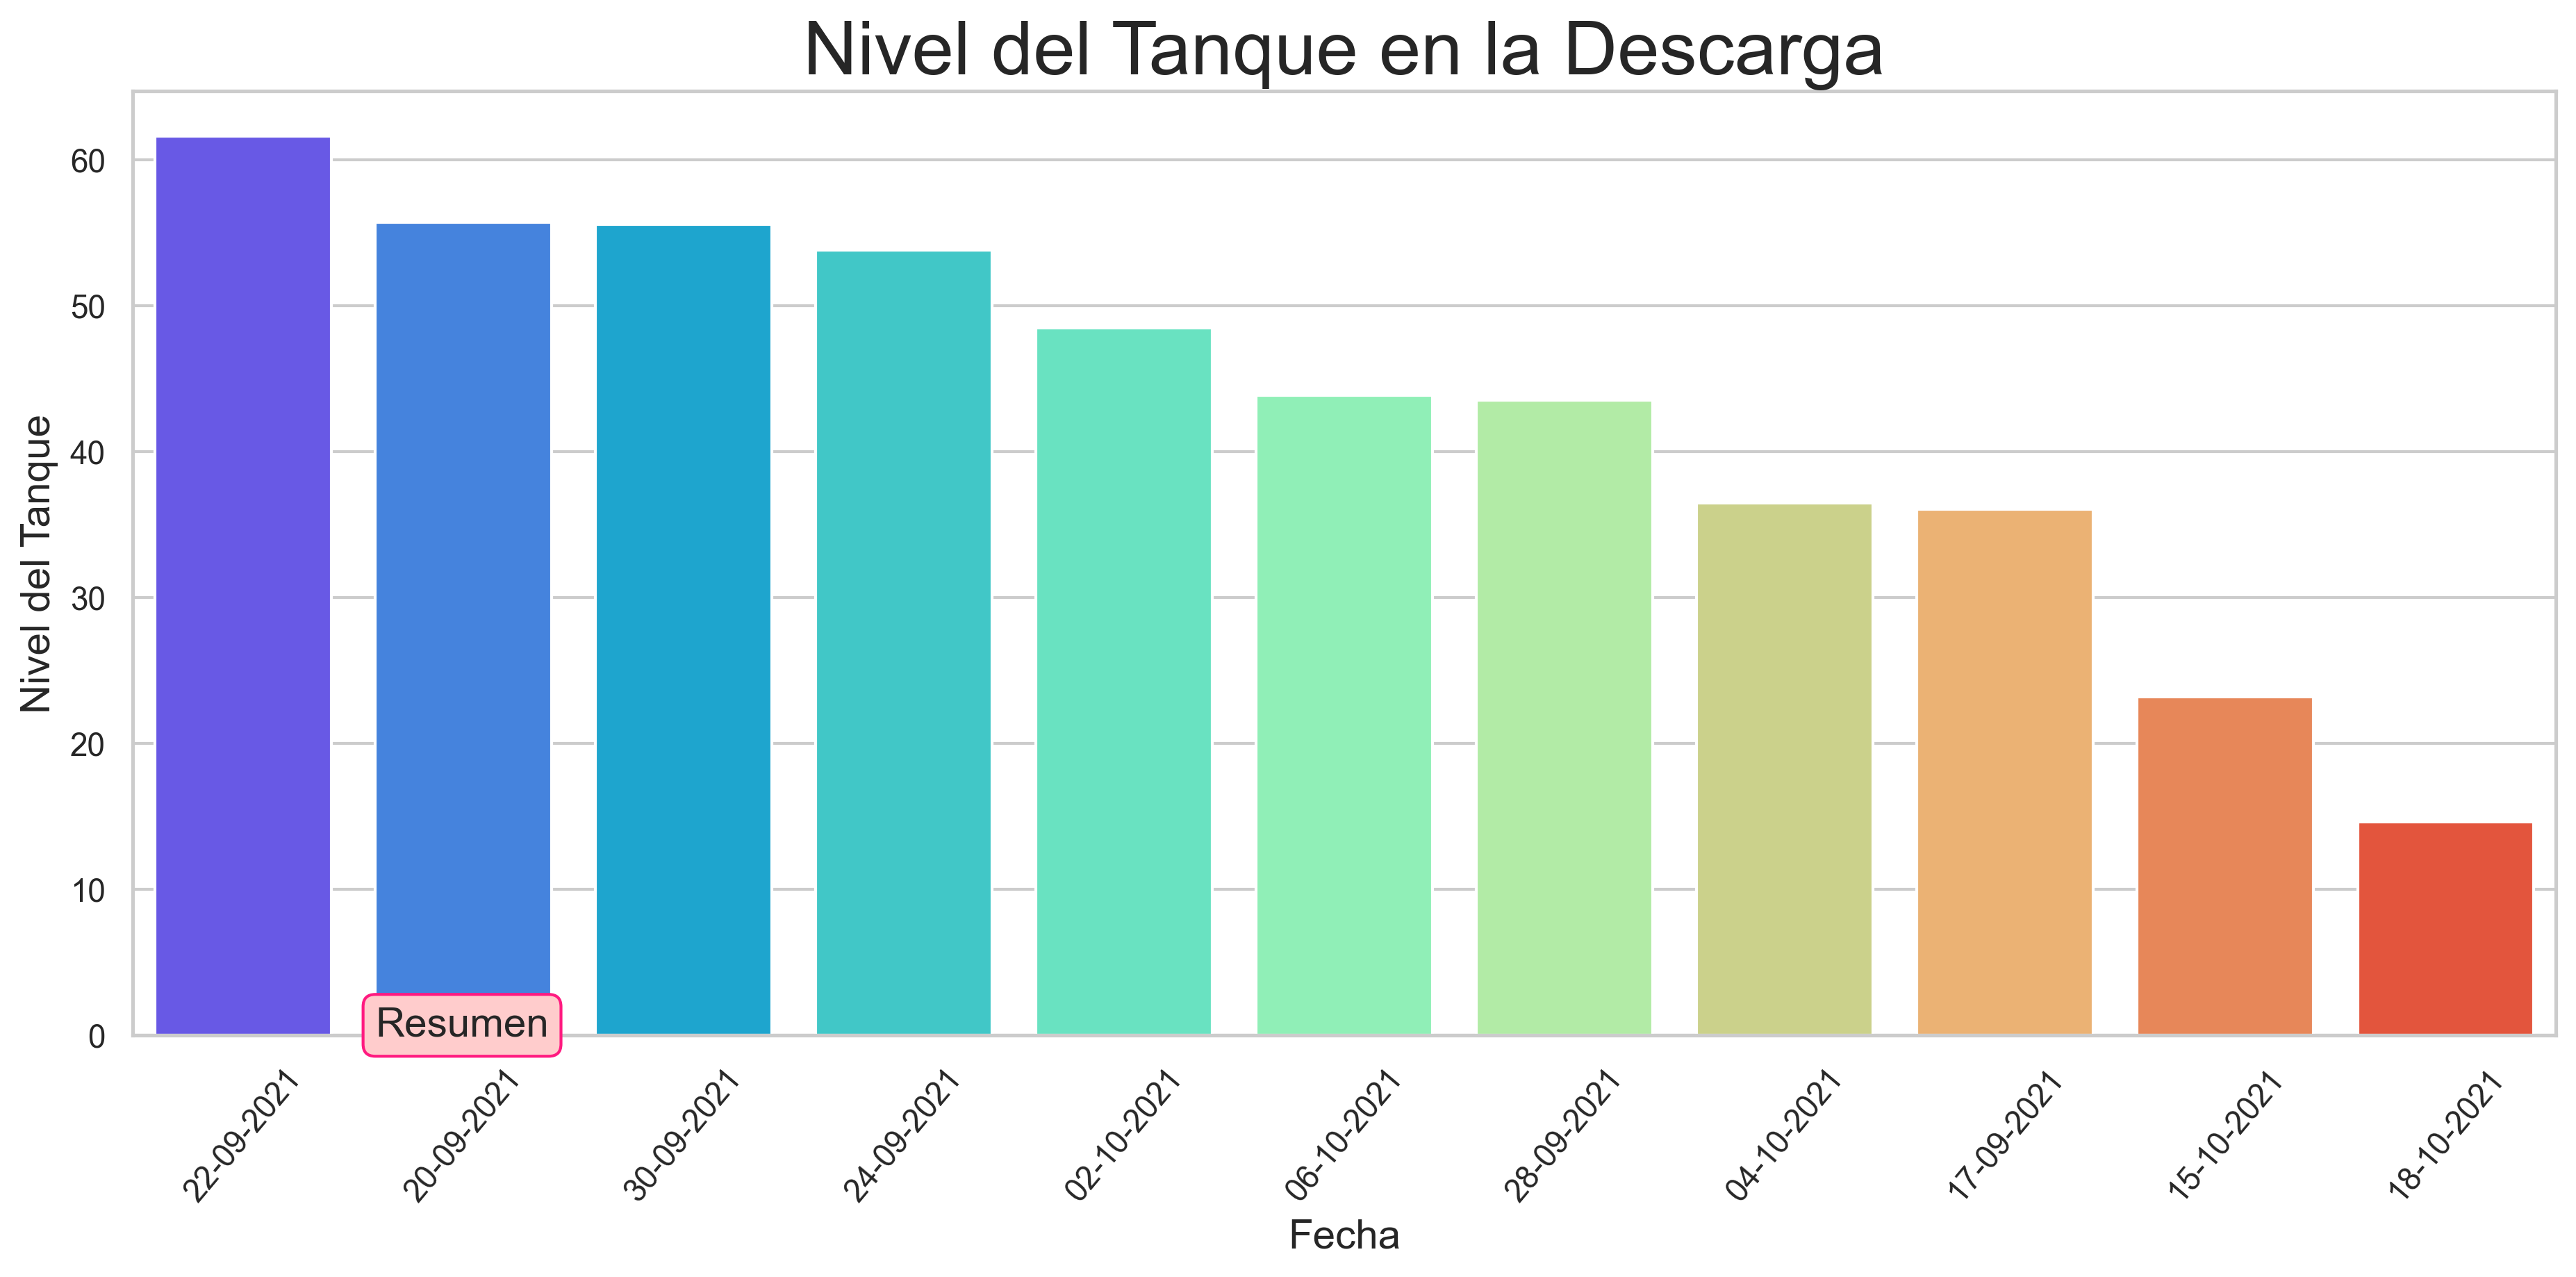

In [55]:
# Graficamos:
fig = plt.figure(figsize=(15,6), dpi=300)
ax = fig.gca()
figure=sns.barplot(x='Date',y='Nivel (%)',data=descargas_df,palette=pal)
figure.set_title("Nivel del Tanque en la Descarga",fontsize=26)
plt.xticks(rotation=50)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Nivel del Tanque", fontsize=14)
plt.text(0.6, 0.7, "Resumen", size=50,fontsize=14,
         ha="left", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.1, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )
plt.show()
